_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [119]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train_data = pd.read_csv(train_url)
test_data  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [184]:
train = train_data.copy()
test = test_data.copy()

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

Before I begin, I predict that Inspection ID is a leaky feature. There are exactly 51916 unique inspection ID's in in the training dataset. Therefore it should not be showing this much weight in the cross-validation of the model. 

In [185]:
import category_encoders as ce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [186]:
def wrangle(X):
    X = X.copy()
    
    X['Violations'] = X['Violations'].fillna('0')
    
    # Violations is a bunch of information in a string. I want the number of violations that occurred at a location.
    # This list comporehension finds that based on the number of | dividing the violations. 
    # Null values are treated as instances where no violations were recorded. 
    
    count = []
    for i in np.arange(len(X)):
        if X['Violations'].iloc[i] == '0':
            count.append(0)
        elif X['Violations'].iloc[i].count('|') > 0:
            count.append(X['Violations'].iloc[i].count('|')+2)
        else:
            count.append(1)
        
    X['Violation Count'] = count
    
        #  There are a lot of a noisy columns in the dataframe.        
    #X = X.drop(columns = ['Inspection ID','DBA Name','AKA Name','License #','Address','State','Latitude','Longitude','Location','Violations'])
    
    X = X.drop(columns = ['Violation Count'])
    X = X.dropna()
    
    
    encoder = ce.OrdinalEncoder()
    X = encoder.fit_transform(X)
    
    return X
    

In [187]:
train = wrangle(train)
test = wrangle(test)

In [188]:
X_train = train.drop(columns = 'Fail')
y_train = train['Fail']

X_test  = test.drop(columns = 'Fail')
y_test  = test['Fail']

In [189]:
X_train.isnull().sum()

Inspection ID      0
DBA Name           0
AKA Name           0
License #          0
Facility Type      0
Risk               0
Address            0
City               0
State              0
Zip                0
Inspection Date    0
Inspection Type    0
Violations         0
Latitude           0
Longitude          0
Location           0
dtype: int64

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._

In [190]:
# Randomized search to find the optimal hyperparameters. 
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

param_distributions = {
    'n_estimators': randint(50, 500), 
    'max_depth': randint(1,5)
}

search = RandomizedSearchCV(
    estimator = XGBClassifier(n_jobs = -1, random_state = 42),
    param_distributions = param_distributions, 
    scoring = 'roc_auc',
    n_iter = 10,
    n_jobs = -1,
    cv= 3,
    verbose = 10,
    return_train_score = True,
    random_state = 42
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   35.4s remaining:   20.5s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   38.8s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   47.5s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   48.6s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2958a630>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2958a8d0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [191]:
# creating variable name for the best_estimator object. 
best = search.best_estimator_
# Best ROC AUC Score
search.best_score_

0.7076428589263989

### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

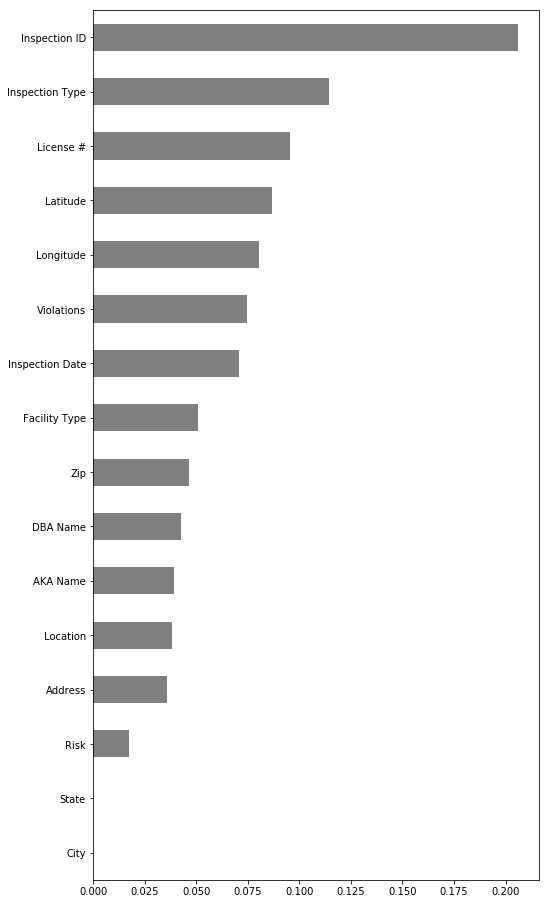

In [192]:
# Let's look at feature importances!

figsize = (7, 14)
importances = pd.Series(best.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color = 'gray', figsize = figsize);

In [193]:
# Lets Cross Reference that with the Permutation Importance. 

import eli5
from eli5.sklearn import PermutationImportance

# In its current form, eli5 doesn't work with pandas and XGBoost. It needs to be an array. 
## Likely because it renames the columns to some hardcoded value. 
### https://www.kaggle.com/dansbecker/permutation-importance#392299
X_train_dbg = X_train.values
y_train_dbg = y_train.values
X_test_dbg = X_test.values
y_test_dbg = y_test.values

# The model also needs to fit with the nd.array data type
best.fit(X_train_dbg, y_train_dbg)

permuter = PermutationImportance(best, scoring = 'roc_auc',
                                 n_iter = 4, random_state = 42)

permuter.fit(X_test_dbg, y_test_dbg)

feature_names = X_test.columns.tolist()
eli5.show_weights(permuter, top = None, feature_names = feature_names)

Weight,Feature
0.0493 ± 0.0045,Inspection ID
0.0237 ± 0.0025,License #
0.0228 ± 0.0005,Inspection Type
0.0195 ± 0.0015,Violations
0.0125 ± 0.0017,Zip
0.0101 ± 0.0021,Longitude
0.0095 ± 0.0024,Latitude
0.0017 ± 0.0012,AKA Name
0.0015 ± 0.0005,Location
0.0005 ± 0.0003,Address


In [ ]:
# I want to remove any noisy features. 
mask = permuter.feature_importances_ > 0
features = X_train.columns[mask]




### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._

Gradient descent is attempting to minimize the **cost** or **error** a predicition model. It attempts to iteratively decrease the error of the prediction until reaching a local minimum on the cost function. It does so by taking the partial derivative of the cost function and attempting to find the point where the derivative (or slope) is 0. 

The "Learning Rate" or "Alpha" is the size of the "step" taking in each iteration when trying to find the minimum of the cost function. A larger learning rate will work faster, but can overshoot. A smaller learning rate can be more precise, but takes more iterations to find the minimum. 

In [134]:
train_data.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [135]:
train_data['Inspection Type'].unique()

array(['Canvass', 'Complaint Re-Inspection', 'Canvass Re-Inspection',
       'License Re-Inspection', 'License', 'Complaint',
       'Short Form Complaint', 'Special Events (Festivals)',
       'Consultation', 'Task Force Liquor 1475', 'Tag Removal',
       'Complaint-Fire', 'License-Task Force',
       'Suspected Food Poisoning Re-inspection', 'Out of Business',
       'Complaint-Fire Re-inspection', 'TASK FORCE LIQUOR 1470',
       'Suspected Food Poisoning', 'Recent Inspection', 'NO ENTRY',
       'Short Form Fire-Complaint', 'KIDS CAFE', 'No Entry', 'no entry',
       'Pre-License Consultation', 'Package Liquor 1474',
       'TASK FORCE LIQUOR (1481)', 'Illegal Operation',
       'LICENSE RENEWAL FOR DAYCARE', 'CANVASS SPECIAL EVENTS',
       'CHANGED COURT DATE', 'TAVERN 1470', 'Non-Inspection',
       'TWO PEOPLE ATE AND GOT SICK.', 'Not Ready',
       'CLOSE-UP/COMPLAINT REINSPECTION', 'SMOKING COMPLAINT',
       'LICENSE WRONG ADDRESS', 'OUT OF BUSINESS',
       'CANVASS/SPECIA

In [133]:
train_data.shape

(51916, 17)